<a href="https://colab.research.google.com/github/Antonio-Villarreal/Deep-Learning-For-Dummies/blob/main/VGG16_Birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!mkdir /content/data

In [3]:
import zipfile

# specify the zip file name
zip_file = '/content/gdrive/MyDrive/Deep Learning/Birds(224x224).zip'

# specify the directory where you want to extract the files
extraction_path = '/content/data'

# extract the files
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Model 1

In [ ]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch
import numpy as np
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt
import zipfile
import glob
import numpy as np
import pandas as pd
import shutil

In [ ]:
train_path = "/content/data/Birds (224x224)/train"
val_path = "/content/data/Birds (224x224)/valid"
test_path = "/content/data/Birds (224x224)/test"

In [ ]:
batch_size = 64
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = torchvision.transforms.Compose([torchvision.transforms.Resize((64, 64)), torchvision.transforms.ToTensor()])


train_folder = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
valid_folder = torchvision.datasets.ImageFolder(root=val_path, transform=transform)
test_folder = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
train_ds = DataLoader(train_folder, batch_size=batch_size)
valid_ds = DataLoader(valid_folder, batch_size=batch_size)
test_ds = DataLoader(test_folder, batch_size=batch_size)

In [ ]:
class CNNModel(nn.Module):
    
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 11, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
n_classes = len(train_folder.classes)
model = CNNModel(n_classes)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)

In [ ]:
epochs = 10
train_steps = len(train_ds)
valid_steps = len(valid_ds)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {"loss": [], "val_loss": [], "val_accuracy": []}
for epoch in range(epochs):
    train_losses = []
    valid_losses = []
    model.train()
    begin = time.time()
    for batch in train_ds:
        optimizer.zero_grad()
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.data.item())
        if len(train_losses) > 0 and len(train_losses) % 20 == 0:
            current = time.time()
            elapsed = current - begin
            print("Epoch %d: [Training] %.2fs/%.2fs"%(epoch + 1, elapsed, elapsed / float(len(train_losses)) * train_steps))
    model.eval()
    num_correct = 0
    num_samples = 0
    begin = time.time()
    for batch in valid_ds:
        optimizer.zero_grad()
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)
        valid_losses.append(loss.data.item())
        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_samples += correct.shape[0]
        if len(valid_losses) > 0 and len(valid_losses) % 10 == 0:
            current = time.time()
            elapsed = current - begin
            print("Epoch %d: [Validation] %.2fs/%.2fs"%(epoch + 1, elapsed, elapsed / float(len(valid_losses)) * valid_steps))
    train_loss = torch.mean(torch.Tensor(train_losses)).item()
    valid_loss = torch.mean(torch.Tensor(valid_losses)).item()
    accuracy = num_correct / num_samples if num_samples > 0 else 0
    metrics["loss"].append(train_loss)
    metrics["val_loss"].append(valid_loss)
    metrics["val_accuracy"].append(accuracy)
    print("Training Loss: %.2f Validation Loss: %.2f accuracy: %.2f" %(train_loss, valid_loss, accuracy))

In [ ]:
pd.DataFrame(metrics).plot()

# Model 2

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.image as mpimg
import plotly.express as px
from sklearn.manifold import TSNE
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import decomposition

import os

In [66]:
birdSpecies = pd.read_csv('/content/data/Birds (224x224)/birds.csv')
birdSpecies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75126 entries, 0 to 75125
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   class id          75126 non-null  int64 
 1   filepaths         75126 non-null  object
 2   labels            75126 non-null  object
 3   scientific label  75126 non-null  object
 4   data set          75126 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.9+ MB


In [67]:
birdSpecies.head(5)

,class id,filepaths,labels,scientific label,data set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train


In [68]:
result = birdSpecies.groupby(['labels']).size()
result.describe()

count    450.000000
mean     166.946667
std       17.408029
min      140.000000
25%      154.000000
50%      165.000000
75%      173.000000
max      258.000000
dtype: float64

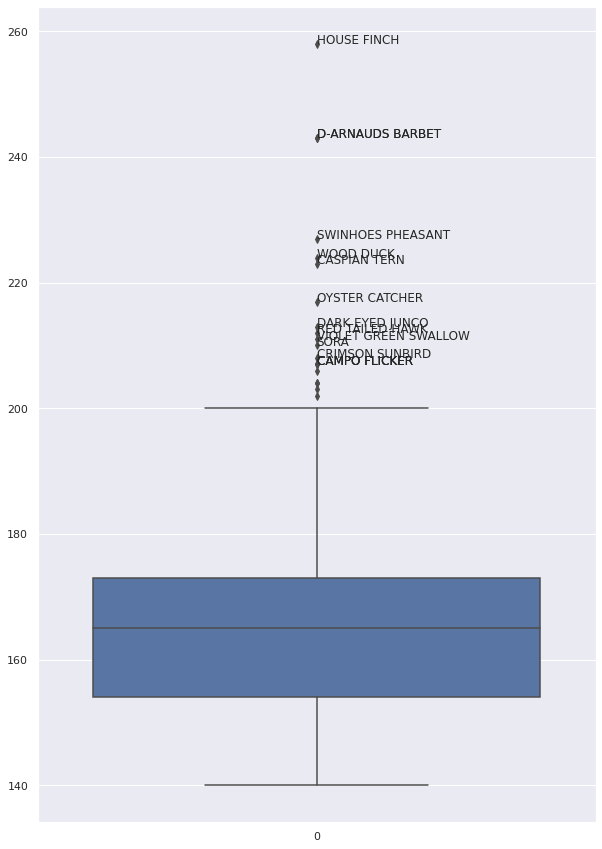

In [69]:
sns.set(rc = {'figure.figsize':(10,15)})
ax = sns.boxplot(data=result)
q1 = 139
q3 = 166
outlier_top = q3 + 1.5 * (q3 - q1)
outlier_bottom = q1 - 1.5 * (q3 - q1)

for val in result:
    if val > outlier_top or val < outlier_bottom:
        label = result[result == val].index[0]
        plt.text(x=0, y=val, s=label)

In [70]:
# size() is equivalent to counting the distinct rows
result = birdSpecies.groupby(['data set']).size()
result = result.sort_values(ascending=False)
text = np.around([result.values[0], result.values[1], result.values[2]]/result.values.sum()*100,2)
# plot the result
sns.set(rc = {'figure.figsize':(8,10)})
fig = px.bar(result, x=result.index, y=result.values, text=text, 
             title="Birds in each data set", labels={"y":"Count"})
fig.show()

In [71]:
local_path = '/content/data/Birds (224x224)'

In [72]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchsummary import summary

In [ ]:
# import PIL.Image as Image
# pathset = []
# fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(15, 15))
# for j in range(5):
#     sample = birdSpecies.sample()
#     species = sample['labels'].to_string(index=False)
#     index = sample.index
#     filepath = str(sample.filepaths.values)[2:-2]
#     pathset.append(local_path + filepath)
#     random_bird = mpimg.imread(local_path + "/" + filepath)
#     plt.imshow(random_bird)
#     axs[0, j].imshow(random_bird)
#     axs[0, j].set_title(species)
#     axs[0, j].axis('off')
    
#     # Normalize RGB
#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
#         transforms.ToPILImage()
#     ])
#     pil_norm = transform(random_bird)
#     axs[1, j].imshow(pil_norm)
#     axs[1, j].axis('off')

#     # Flip
#     transform = transforms.Compose([
#       transforms.ToTensor(),
#       transforms.RandomHorizontalFlip(p=0.5),
#       transforms.RandomVerticalFlip(p=0.5),
#       transforms.ToPILImage()
#     ])
#     pil_flip = transform(random_bird)
#     axs[2, j].imshow(pil_flip)
#     axs[2, j].axis('off')

#     # Color Jitter
#     transform = transforms.Compose([
#       transforms.ToTensor(),
#       transforms.ColorJitter(contrast=(0,5), saturation=(0,5), hue=(-0.1,0.1)),
#       transforms.ToPILImage()
#     ])
#     pil_jitter = transform(random_bird)
#     axs[3, j].imshow(pil_jitter)
#     axs[3, j].axis('off')

In [75]:
train_dir = '/content/data/Birds (224x224)/train'
test_dir = '/content/data/Birds (224x224)/test'
val_dir = '/content/data/Birds (224x224)/valid'

In [76]:
# All images has dimension in 224 X 224 X 3, in which the 3 represents RGB images. 
# The input dimension 224 x 224 is same as the model required. 
# Data is normalized while transform to pytorch datasets.

transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root=train_dir, transform=transformations)
test_data = datasets.ImageFolder(root=test_dir, transform=transformations)
valid_data = datasets.ImageFolder(root=val_dir, transform=transformations)

In [77]:
import pandas as pd
class_dict = pd.read_csv('/content/data/Birds (224x224)/birds.csv')
classes = list(range(1,451))
print(len(classes))

450


In [78]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16

In [79]:
# obtain training indices that will be used for validation
num_train, num_valid = len(train_data), len(valid_data)
train_index, valid_index = list(range(num_train)), list(range(num_valid))
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

In [80]:
def train (n_epoch, base_model, train_loader, optimizer, criterion, valid_loader):
  for epoch in range(n_epoch):  # loop over the dataset multiple times

    print('Epoch: ', epoch+1)
    
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    train_loss = 0
    valid_loss = 0
    
    base_model.train()
    for images, labels in train_loader:
        
        images = images.to(device)
        
        #Reset Grads
        optimizer.zero_grad()
        
        #Forward ->
        outputs = base_model(images).to("cpu")
        
        #Calculate Loss & Backward, Update Weights (Step)
        loss = criterion(outputs, labels)
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    
    
    #Validation
    base_model.eval()
    for images, labels in valid_loader:
        
        images = images.to(device)
        
        #Forward ->
        preds = base_model(images).to("cpu")
        
        #Calculate Loss
        loss = criterion(preds, labels)
        valid_loss += loss.item() * images.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(preds, 1)

        # compare predictions to true label
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        # calculate test accuracy for each object class
        for i in range(len(labels)):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    print('\nValid Accuracy: %2d%%' % 
          (100. * np.sum(class_correct) / np.sum(class_total)))
    
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    #Print Epoch Statistics
    print("Train Loss = {}".format(round(train_loss, 4)))
    print("Valid Loss = {}".format(round(valid_loss, 4)))

In [81]:
def test (classes, base_model, test_loader, criterion):
  # initialize lists to monitor test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))
  base_model.eval() # prep model for evaluation

  for data, target in test_loader:

      data = data.to(device)

      # forward pass: compute predicted outputs by passing inputs to the model
      output = base_model(data).to("cpu")
      # calculate the loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item()*data.size(0)

      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)

      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))

      # calculate test accuracy for each object class
      for i in range(len(target)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
        
  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.sampler)
  print('Test Loss: {:.6f}\n'.format(test_loss))
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [82]:
from torchvision import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = models.vgg19(pretrained=True)

# turn training false for all layers, other than fc layer
for param in base_model.parameters():
    param.requires_grad = False
    
base_model.classifier

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.



Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [83]:
base_model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, 2048),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(2048, 450)
    )

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = base_model.to(device)

In [86]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr = 0.0001)

In [87]:
summary(base_model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [88]:
train(10, base_model, train_loader, optimizer, criterion, valid_loader)

Epoch:  1

Valid Accuracy: 75%
Train Loss = 2.6107
Valid Loss = 0.8309
Epoch:  2

Valid Accuracy: 82%
Train Loss = 1.0368
Valid Loss = 0.6295
Epoch:  3

Valid Accuracy: 82%
Train Loss = 0.7002
Valid Loss = 0.5389
Epoch:  4

Valid Accuracy: 84%
Train Loss = 0.5356
Valid Loss = 0.5734
Epoch:  5

Valid Accuracy: 86%
Train Loss = 0.4449
Valid Loss = 0.5442
Epoch:  6

Valid Accuracy: 87%
Train Loss = 0.3815
Valid Loss = 0.522
Epoch:  7

Valid Accuracy: 89%
Train Loss = 0.3463
Valid Loss = 0.4732
Epoch:  8

Valid Accuracy: 86%
Train Loss = 0.3267
Valid Loss = 0.5359
Epoch:  9


KeyboardInterrupt: ignored

In [89]:
test(classes, base_model, test_loader, criterion)

Test Loss: 0.315588


Test Accuracy (Overall): 91% (2066/2250)
